In [1]:
import DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations
using Plots

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

include("../emodnet_bio_grid.jl");

ErrorException: could not open file /home/ctroupin/ULg/Tools/DIVAndNN/emodnet_bio_grid.jl

In [6]:
function read_benthos(filename::String)
    data,header = readdlm(fname,',',header = true)
    header = header[:]

    # "data","x","y","sta","g1","g2","g3"
    dataname = Vector{String}(data[:,findfirst(header .== "data")]);

    obslon = Vector{Float64}(data[:,findfirst(header .== "x")]);
    obslat = Vector{Float64}(data[:,findfirst(header .== "y")]);

    stationname = Vector{String}(data[:,findfirst(header .== "sta")]);

    g1 = Vector{Float64}(data[:,findfirst(header .== "g1")]);
    g2 = Vector{Float64}(data[:,findfirst(header .== "g2")]);
    g3 = Vector{Float64}(data[:,findfirst(header .== "g3")]);
    
    return obslon, obslat, g1, g2, g3
end

read_benthos (generic function with 1 method)

## Load and plot data

In [15]:
fname = joinpath(datadir, "Olivier-Benthos/tab.csv");
obslon, obslat, g1, g2, g3 = read_benthos(fname);
@info extrema(obslat)
@info extrema(obslon)

┌ Info: (41.3894, 72.579834)
└ @ Main In[15]:3
┌ Info: (-9.39937, 34.328014)
└ @ Main In[15]:4


In [17]:
fname = joinpath(datadir, "Olivier-Benthos/tabsr.csv");
obslon2, obslat2, _ , _ , _ = read_benthos(fname);
@info extrema(obslat2)
@info extrema(obslon2)

┌ Info: (36.8451, 72.579834)
└ @ Main In[17]:3
┌ Info: (-9.718917, 34.328014)
└ @ Main In[17]:4


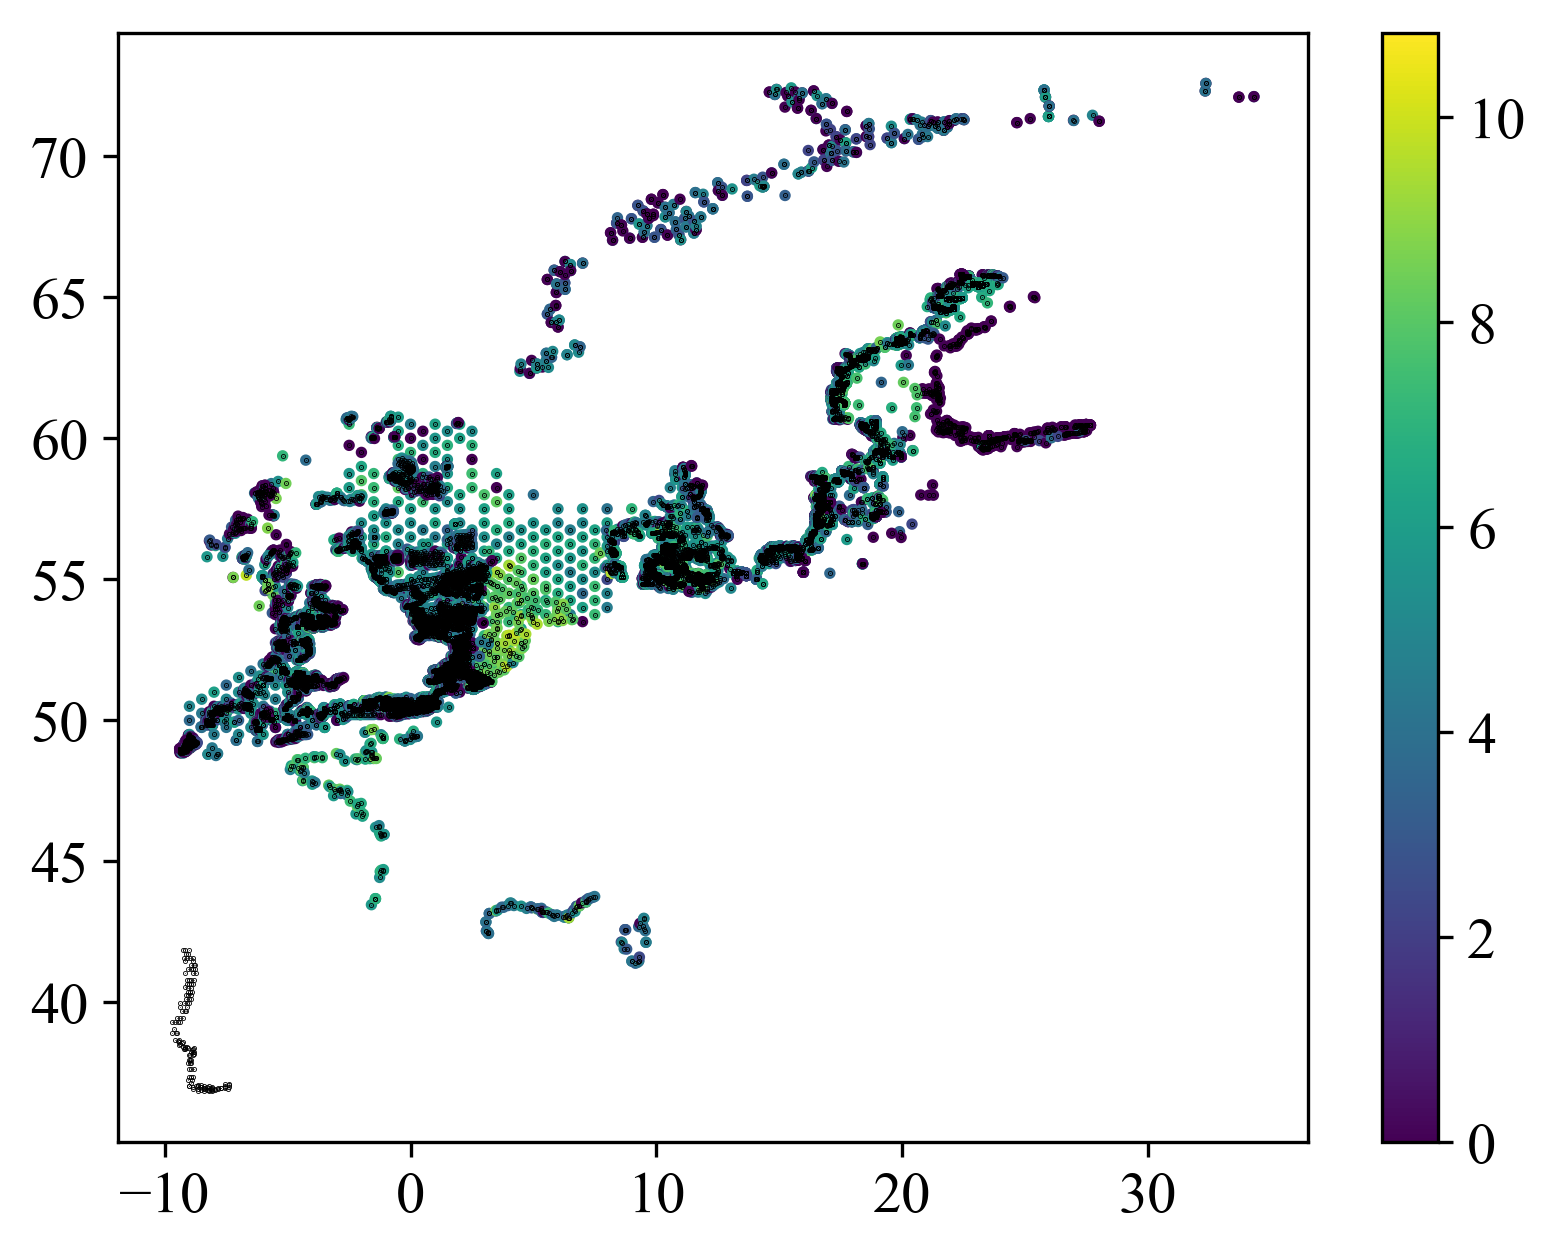

PyObject <matplotlib.colorbar.Colorbar object at 0x7f60f5c4ef98>

In [19]:
scat = scatter(obslon, obslat, s=3, c=log.(g1.+1))
plot(obslon2, obslat2, "ko", markersize=0.2)
colorbar(scat)

In [40]:
pyplot()

Plots.PyPlotBackend()

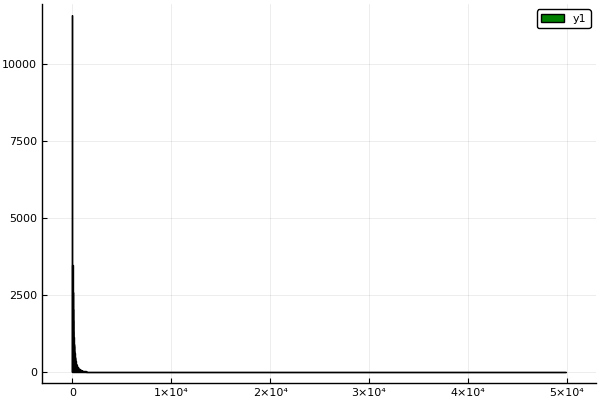

In [54]:
histogram(g1, color="green")

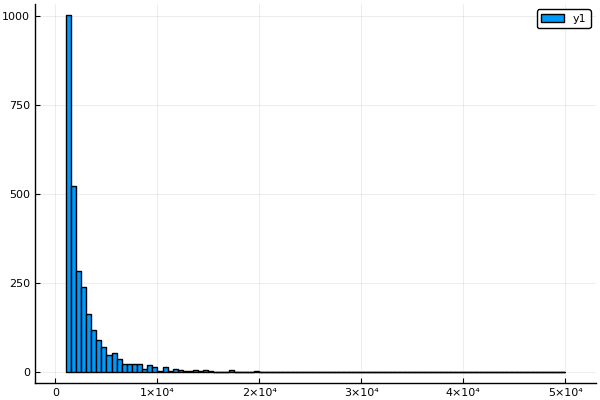

In [67]:
histogram(g1[g1 .> 1000])

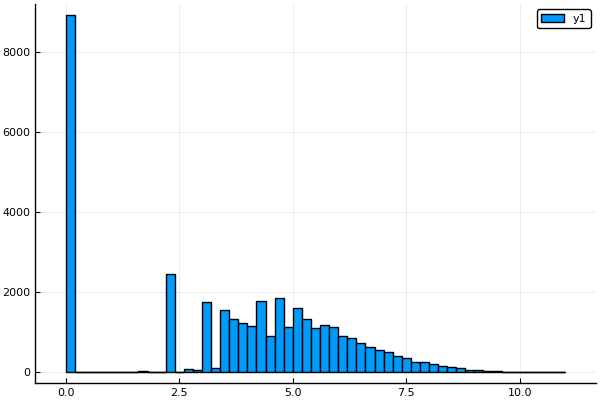

In [55]:
histogram(log.(g1.+1))

## Parameters

In [146]:
coordinates = [-10., 35., 36., 73.];
dlon = 1/10.;
dlat = 1/10.;

# Grid
longrid = range(coordinates[1], stop=coordinates[2], step=dlon);
latgrid = range(coordinates[3], stop=coordinates[4], step=dlat);
xi,yi = DIVAnd.ndgrid(longrid, latgrid);

In [147]:
# Reference field
fref0 = mean(g1)
fref1 = mean(log10.(g1 .+ 1))
fref2 = log10(mean(g1) + 1)
fref3 = median(g1)
fref4 = median(log10.(g1 .+ 1))
fref5 = log10(median(g1) + 1)
fref6 = mean(g1[g1 .> 1000.])
fref0, fref1, fref2, fref3, fref4, fref5, fref6 # fref4 == fref5  😸

(360.9649838336674, 1.6069470526957537, 2.5586665593084046, 60.0, 1.7853298350107671, 1.7853298350107671, 3049.5356455402816)

In [148]:
# Mask
topodir = "/home/ctroupin/Projects/Diva-Workshops/notebooks/data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = load_bath(topofile,true,longrid,latgrid);
    xmask, ymask, mmask = load_mask(topofile,true,longrid,latgrid,[0]);
else
    @error "Bathymetry file doesn't exist"
end

(-10.0:0.1:35.0, 36.0:0.1:73.0, Bool[true true … true true; true true … true true; … ; true true … true true; true true … true true])

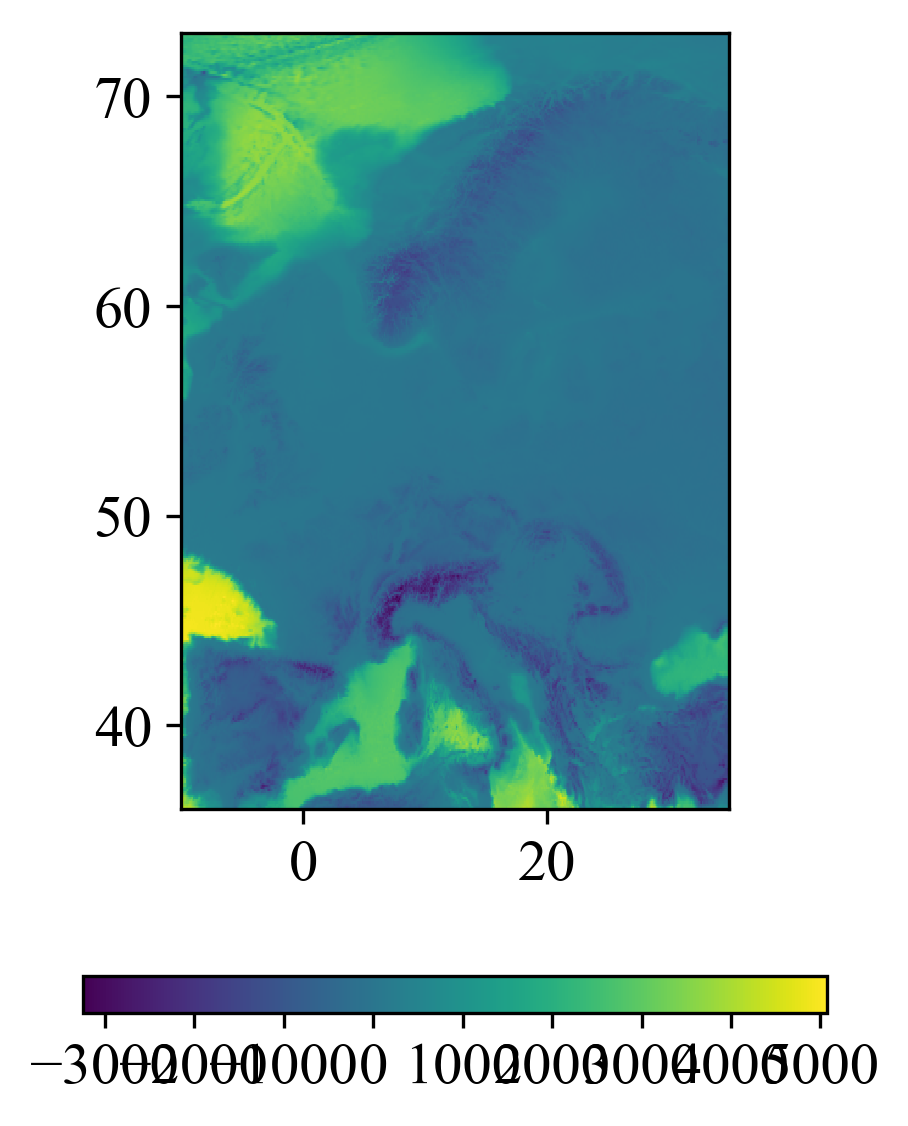

In [150]:
pcolor(bx, by, permutedims(b, [2, 1])); 
colorbar(orientation="horizontal", shrink=0.5)
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

In [151]:
# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

In [ ]:
# correlation length
len = 3.;
# obs. error variance normalized by the background error variance
epsilon2 = 2.;

# fi is the interpolated field
g1log = log.(g1.+1);
g2log = log.(g2.+1);
g3log = log.(g3.+1);

@time fi1,s = DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslon,obslat), g1log .- mean(g1log),len,epsilon2,alphabc=2);

@time fi2,s = DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslon,obslat), g2log .- mean(g2log),len,epsilon2,alphabc=2);

@time fi3,s = DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslon,obslat), g3log .- mean(g3log),len,epsilon2,alphabc=2);

In [185]:
e
totalfield = fi1+fi2+fi3.+ mean(g1log).+ mean(g2log).+ mean(g3log);

  1.593651 seconds (2.30 M allocations: 1.450 GiB, 42.77% gc time)
  1.517536 seconds (2.30 M allocations: 1.450 GiB, 44.51% gc time)
  1.474341 seconds (2.30 M allocations: 1.450 GiB, 44.23% gc time)


In [193]:
exp(log(10))

10.000000000000002

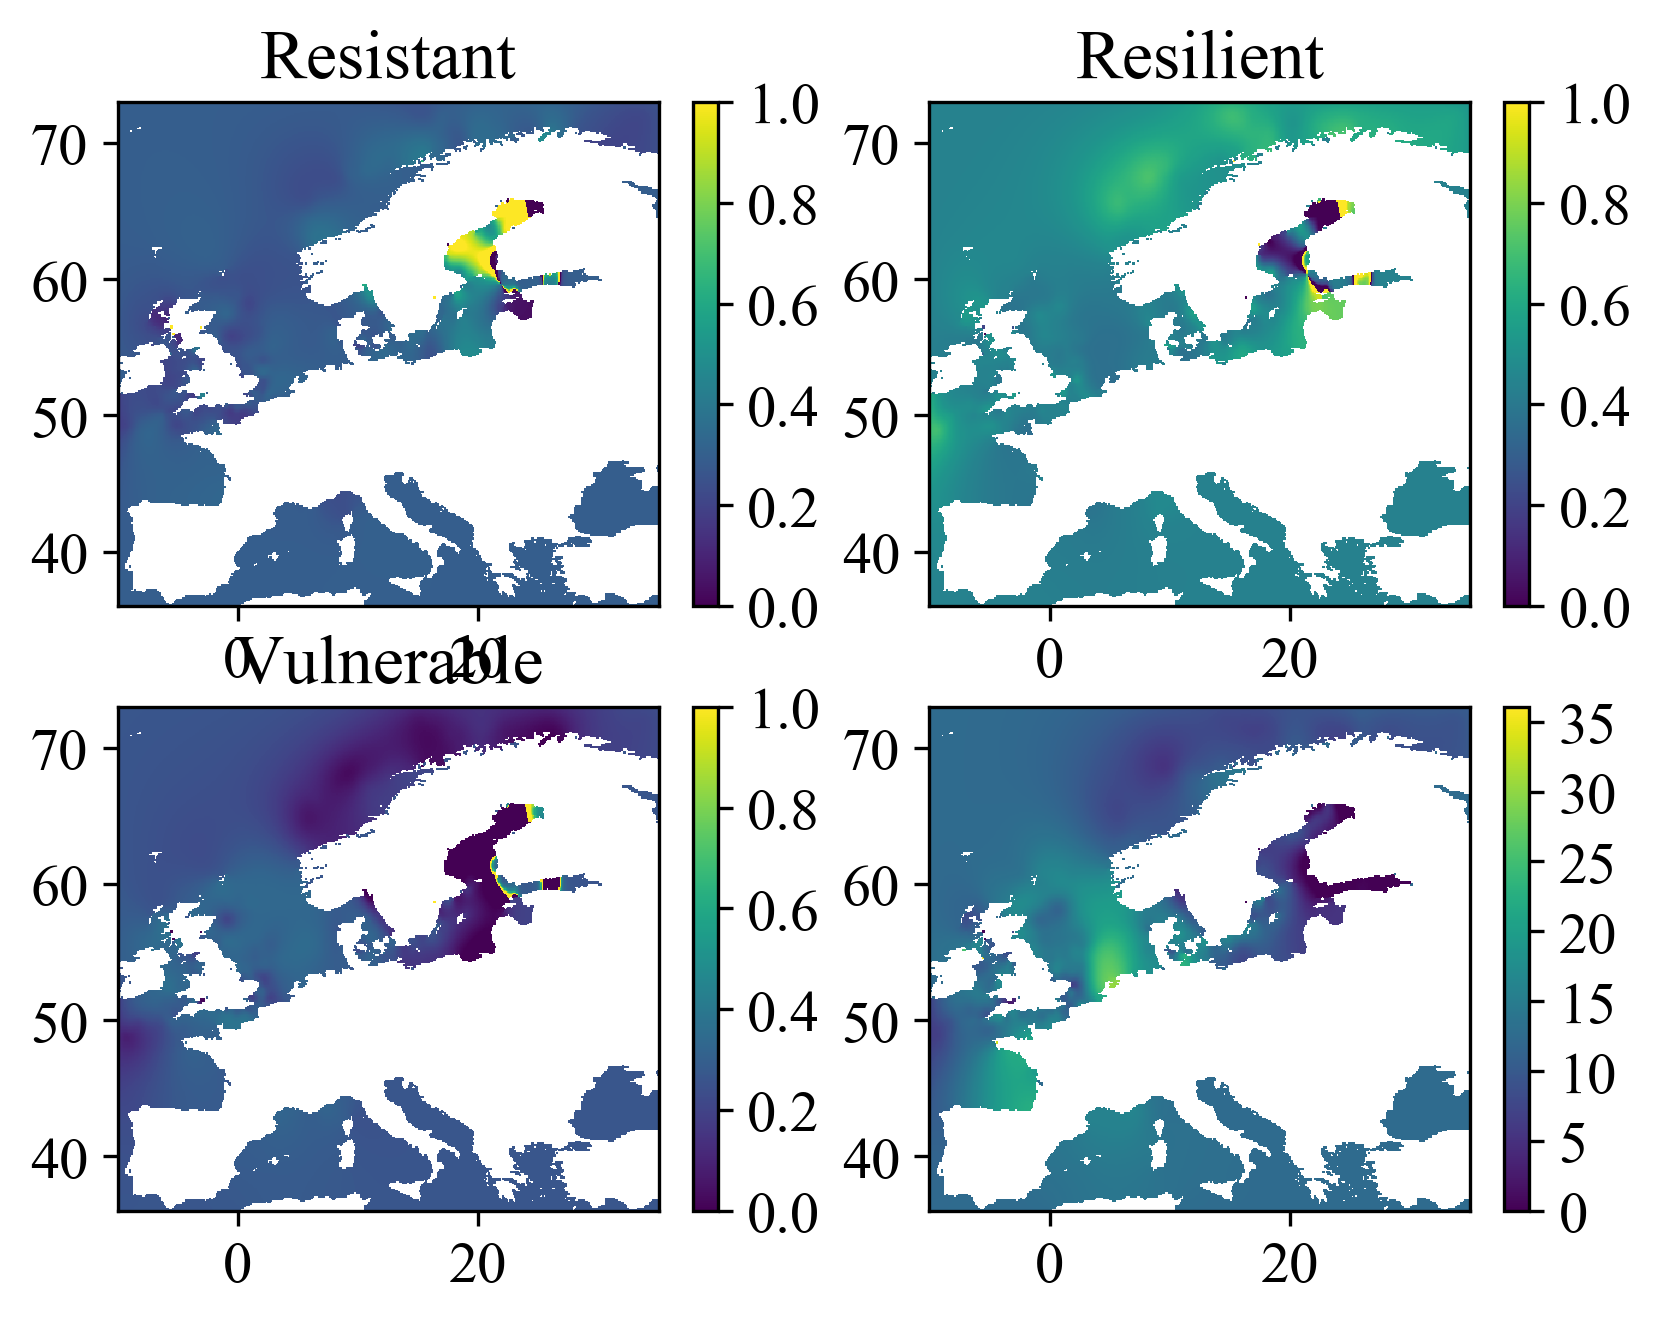

PyObject <matplotlib.colorbar.Colorbar object at 0x7f609d339630>

In [191]:
figure
subplot(2,2,1)
title("Resistant")
pcolormesh(longrid, latgrid, permutedims((fi1.+mean(g1log))./totalfield, [2,1]), 
    vmin=0, vmax=1)
colorbar()
#scatter(obslon, obslat, s=0.5, c=log.(g1.+1), vmin=0, vmax=10)
subplot(2,2,2)
title("Resilient")
pcolormesh(longrid, latgrid, permutedims((fi2.+mean(g2log))./totalfield, [2,1]), 
    vmin=0, vmax=1)
colorbar()
subplot(2,2,3)
title("Vulnerable")
pcolormesh(longrid, latgrid, permutedims((fi3.+mean(g3log))./totalfield, [2,1]), 
    vmin=0, vmax=1)
colorbar()
subplot(2,2,4)
pcolormesh(longrid, latgrid, permutedims(totalfield, [2,1]), vmin=0)
colorbar()